# 🤖 Supervised Learning for Oil Well Fault Detection

## What is Supervised Classification?

Supervised learning uses labeled training data to predict categories for new data.

**Key Components:**
- **Training Data**: Examples with known answers (features + labels)
- **Features**: Sensor measurements (input)
- **Labels**: Fault types 0-9 (output)
- **Model**: Algorithm that learns patterns
- **Evaluation**: How well the model performs

## Our Problem: 3W Oil Well Classification

**Goal**: Predict oil well fault types from sensor data

**Input**: Time series from sensors (P-PDG, P-TPT, T-TPT)
**Output**: Fault classes (0=normal, 1-9=different faults)
**Challenge**: Multiple classes, imbalanced data, high dimensions

In [1]:
# ============================================================
# LOAD 3W DATASET
# ============================================================

import sys
import numpy as np

# Add src directory to path
sys.path.append("src")
from src import config
from src.supervised_classification import (
    load_3w_data,
)

# Load dataset using utility function
(train_dfs, train_classes, train_fold_info, test_dfs, test_classes, test_fold_info) = (
    load_3w_data(config, verbose=True)
)

Loading 3W Dataset for Classification
Found 3 folds
✅ Data loaded successfully!
   Training windows: 70361
   Test windows: 14731
   Window shape: (300, 4)


## Data Loading for Supervised Learning

**Key requirements:**
- **Labeled data** - Examples with known fault classifications
- **Train/test split** - Separate data for training and unbiased evaluation
- **Cross-validation** - Multiple data splits for robust performance estimates

**3W Dataset structure:**
- **Training data** - Used to teach algorithms to recognize patterns
- **Test data** - Unseen data to evaluate real-world performance
- **Windowed format** - Time series converted to fixed-size sequences
- **Class labels** - Fault types (0=normal, 1-8=different fault conditions)

# 📊 Classification Configuration

## Class Selection

Choose which fault types to analyze:

```python
selected_classes = [3, 4, 8]  # Focus on specific faults
selected_classes = [1, 2, 3, 4, 5]  # Early fault types  
selected_classes = None  # All fault types (exclude normal operation)
```

In [2]:
# ============================================================
# CONFIGURE CLASSIFICATION
# ============================================================

from src.supervised_classification import (
    validate_configuration,
    print_class_distribution_analysis,
)

# Configuration
selected_classes = [3, 4, 8]  # Choose fault types to analyze
balance_test = False  # Keep original test distribution
min_test_samples_per_class = 300

print("Classification Configuration:")
print("=" * 35)

# Verify data availability
if not (train_dfs and test_dfs):
    print("❌ No data available. Run the data loading cell first.")
else:
    print(f"✅ Data ready: {len(train_dfs)} train, {len(test_dfs)} test windows")

    # Validate configuration
    config_valid = validate_configuration(selected_classes, test_classes, verbose=True)

    # Check fold information
    fold_available = test_fold_info is not None and len(test_fold_info) == len(test_dfs)
    if fold_available:
        unique_folds = sorted(set(test_fold_info))
        print(f"✅ Fold information: {len(unique_folds)} folds detected")

        # Print comprehensive class distribution analysis using module function
        print_class_distribution_analysis(
            test_classes=test_classes,
            test_fold_info=test_fold_info,
            selected_classes=selected_classes,
            verbose=True,
        )

    else:
        print("⚠️ No fold information available")

Classification Configuration:
✅ Data ready: 70361 train, 14731 test windows
Selected classes: [3, 4, 8]
✅ Fold information: 3 folds detected

📊 CLASS DISTRIBUTION BY TEST FOLD

🗂️  fold_1:
   Total samples: 4,794
   Class 0: 374 samples (7.8%)
   Class 1: 126 samples (2.6%)
   Class 2: 46 samples (1.0%)
   Class 3: 242 samples (5.0%)
   Class 4: 136 samples (2.8%)
   Class 5: 63 samples (1.3%)
   Class 6: 16 samples (0.3%)
   Class 7: 3,150 samples (65.7%)
   Class 8: 382 samples (8.0%)
   Class 9: 259 samples (5.4%)
   Selected classes in fold: [3, 4, 8]
   Selected classes total: 760 samples (15.9%)

🗂️  fold_2:
   Total samples: 5,519
   Class 0: 374 samples (6.8%)
   Class 1: 70 samples (1.3%)
   Class 2: 58 samples (1.1%)
   Class 3: 238 samples (4.3%)
   Class 4: 133 samples (2.4%)
   Class 5: 283 samples (5.1%)
   Class 6: 45 samples (0.8%)
   Class 7: 3,316 samples (60.1%)
   Class 8: 820 samples (14.9%)
   Class 9: 182 samples (3.3%)
   Selected classes in fold: [3, 4, 8]
   S

## Multi-Algorithm Training Strategy

**Algorithm categories:**
- **Tree-based** - can be (depends on the algoritm and application): Interpretable, handle non-linear patterns , robust to outliers
- **Support Vector Machines** - Effective for high-dimensional data, kernel flexibility
- **Neural Networks** - Can learn complex patterns, require more data and tuning

**Evaluation strategy:**
- **Cross-validation** - Test on multiple data splits for robust estimates
- **Multiple metrics** - Accuracy, precision, recall, F1-score
- **Computational efficiency** - Training time and memory usage

## Tree-Based Algorithms Theory

**Decision Trees:**
- **How they work** - Split data based on feature values to separate classes
- **Interpretability** - Easy to understand and visualize decision paths
- **Strengths** - Handle non-linear patterns, robust to outliers
- **Weaknesses** - Prone to overfitting, unstable (small data changes = different tree)

**Random Forest:**
- **Ensemble method** - Combines many decision trees for better performance
- **Bootstrap aggregating** - Each tree trained on random data subset
- **Feature randomness** - Each split considers random subset of features
- **Benefits** - Reduces overfitting, more stable, provides feature importance

**For oil well data:** Good at capturing threshold-based rules (e.g., "if pressure > X and temperature < Y, then fault type Z")

In [3]:
# ============================================================
# DECISION TREES ANALYSIS - BY FOLD/FOLDER
# ============================================================

from src.supervised_classification import (
    tree_based_fold_analysis,
    print_tree_analysis_results,
)

# Check if data is available
if not (train_dfs and test_dfs):
    print("❌ No data available. Run the data loading cell first.")
elif not fold_available:
    print("❌ No fold information available. Cannot analyze by folder.")
else:
    print("🌳 TRAINING TREE-BASED MODELS - BY FOLD/FOLDER")
    print("=" * 50)

    # Run tree-based analysis for each fold (verbose=False to avoid duplicates)
    tree_analysis_results = tree_based_fold_analysis(
        train_dfs=train_dfs,
        train_classes=train_classes,
        test_dfs=test_dfs,
        test_classes=test_classes,
        train_fold_info=train_fold_info,
        test_fold_info=test_fold_info,
        selected_classes=selected_classes,
        balance_classes=True,
        balance_strategy="combined",
        max_samples_per_class=1000,
        verbose=False,  # Set to False to avoid duplicate output
    )

    # Print detailed analysis using module function
    print_tree_analysis_results(tree_analysis_results, selected_classes)

    # Store for potential later use
    tree_fold_analysis = tree_analysis_results

🌳 TRAINING TREE-BASED MODELS - BY FOLD/FOLDER
📁 Processed 3 folds: ['fold_1', 'fold_2', 'fold_3']
🏆 Best Overall: Random Forest from fold_2 (0.987)

📋 DETAILED RESULTS TABLE:
------------------------------------------------------------
  Fold         Model Train Acc Test Acc Overfitting Time (s)
fold_1 Decision Tree     0.984    0.767       0.217    0.961
fold_1 Random Forest     0.990    0.771       0.219    0.487
fold_2 Decision Tree     0.987    0.915       0.073    0.910
fold_2 Random Forest     0.992    0.987       0.005    0.436
fold_3 Decision Tree     0.989    0.492       0.497    0.774
fold_3 Random Forest     0.999    0.521       0.478    0.386

📊 DETAILED FOLD COMPARISON:
----------------------------------------

🌲 Decision Tree by Fold:
   fold_1: 0.767 (overfitting: 0.217)
   fold_2: 0.915 (overfitting: 0.073)
   fold_3: 0.492 (overfitting: 0.497)

🌳 Random Forest by Fold:
   fold_1: 0.771 (overfitting: 0.219)
   fold_2: 0.987 (overfitting: 0.005)
   fold_3: 0.521 (overfit

# ⚡ Support Vector Machines (SVM)

**How SVM Works**: Finds the best boundary (hyperplane) to separate different classes with maximum margin.

**Key Advantages**:
- Effective with high-dimensional data (many features)
- Memory efficient (uses only support vectors)
- Different kernels for different data patterns

**For Oil Well Data**: Handles flattened time series well, RBF kernel captures non-linear sensor patterns.

In [4]:
# ============================================================
# SVM ANALYSIS - BY FOLD/FOLDER
# ============================================================

from src.supervised_classification import (
    svm_based_fold_analysis,
    print_svm_analysis_results,
)

# Check if data is available
if not (train_dfs and test_dfs):
    print("❌ No data available. Run the data loading cell first.")
elif not fold_available:
    print("❌ No fold information available. Cannot analyze by folder.")
else:
    print("⚡ TRAINING SVM MODELS - BY FOLD/FOLDER")
    print("=" * 45)

    # Run SVM-based analysis for each fold (verbose=False to avoid duplicates)
    svm_analysis_results = svm_based_fold_analysis(
        train_dfs=train_dfs,
        train_classes=train_classes,
        test_dfs=test_dfs,
        test_classes=test_classes,
        train_fold_info=train_fold_info,
        test_fold_info=test_fold_info,
        selected_classes=selected_classes,
        balance_classes=True,
        balance_strategy="combined",
        max_samples_per_class=1000,
        verbose=False,  # Set to False to avoid duplicate output
    )

    # Print detailed analysis using module function
    print_svm_analysis_results(svm_analysis_results, selected_classes)

    # Store for potential later use
    svm_fold_analysis = svm_analysis_results

⚡ TRAINING SVM MODELS - BY FOLD/FOLDER
📁 Processed 3 folds: ['fold_1', 'fold_2', 'fold_3']
🏆 Best Overall: RBF SVM from fold_2 (0.983)
⚙️ Training limited to 1000 samples per fold for efficiency

📋 DETAILED RESULTS TABLE:
----------------------------------------------------------------------
  Fold      Model Train Acc Test Acc Overfitting Time (s)  Samples
fold_1 Linear SVM     0.961    0.746       0.215    0.048     1000
fold_1    RBF SVM     0.966    0.786       0.180    0.033     1000
fold_2 Linear SVM     0.938    0.929       0.009    0.109     1000
fold_2    RBF SVM     0.963    0.983      -0.020    0.043     1000
fold_3 Linear SVM     0.928    0.742       0.186    0.100     1000
fold_3    RBF SVM     0.978    0.790       0.188    0.032     1000

📊 DETAILED FOLD COMPARISON:
----------------------------------------

📐 Linear SVM by Fold:
   fold_1: 0.746 (overfitting: 0.215, time: 0.048s)
   fold_2: 0.929 (overfitting: 0.009, time: 0.109s)
   fold_3: 0.742 (overfitting: 0.186, tim

# 🧠 Neural Networks

**How Neural Networks Work**: Interconnected layers of neurons that learn complex patterns through training.

**Key Components**:
- **Neurons**: Process input and apply activation functions
- **Layers**: Input → Hidden → Output
- **Backpropagation**: Adjusts weights based on errors

**Types Used**:
- **Simple NN**: Fast baseline, good for simple patterns
- **Deep NN**: Multiple hidden layers for complex patterns
- **Regularized NN**: Uses dropout to prevent overfitting

**For Time Series**: Can automatically discover patterns in sensor data and handle complex temporal relationships.

In [5]:
# ============================================================
# NEURAL NETWORKS ANALYSIS - BY FOLD/FOLDER
# ============================================================

from src.supervised_classification import (
    neural_network_based_fold_analysis,
    print_neural_network_analysis_results,
)

# Check if data is available
if not (train_dfs and test_dfs):
    print("❌ No data available. Run the data loading cell first.")
elif not fold_available:
    print("❌ No fold information available. Cannot analyze by folder.")
else:
    print("🧠 TRAINING NEURAL NETWORK MODELS - BY FOLD/FOLDER")
    print("=" * 55)

    # Run neural network-based analysis for each fold (verbose=False to avoid duplicates)
    nn_analysis_results = neural_network_based_fold_analysis(
        train_dfs=train_dfs,
        train_classes=train_classes,
        test_dfs=test_dfs,
        test_classes=test_classes,
        train_fold_info=train_fold_info,
        test_fold_info=test_fold_info,
        selected_classes=selected_classes,
        balance_classes=True,
        balance_strategy="combined",
        max_samples_per_class=1000,
        verbose=False,  # Set to False to avoid duplicate output
    )

    # Print detailed analysis using module function
    print_neural_network_analysis_results(nn_analysis_results, selected_classes)

    # Store for potential later use
    nn_fold_analysis = nn_analysis_results

# Print neural network architectures for reference
from src.supervised_classification import print_neural_network_architectures

print_neural_network_architectures()

🧠 TRAINING NEURAL NETWORK MODELS - BY FOLD/FOLDER
📁 Processed 3 folds: ['fold_1', 'fold_2', 'fold_3']
🏆 Best Overall: Deep Neural Network from fold_2 (0.982)
⚙️ Training limited to 1000 samples per fold for efficiency
🔄 Average training iterations: 25

📋 DETAILED RESULTS TABLE:
--------------------------------------------------------------------------------
  Fold                      Model Train Acc Test Acc Overfitting Time (s)  Samples  Iterations
fold_1      Simple Neural Network     0.952    0.773       0.179    0.321     1000          20
fold_1        Deep Neural Network     0.973    0.777       0.196    0.507     1000          27
fold_1 Regularized Neural Network     0.973    0.774       0.199    0.458     1000          25
fold_2      Simple Neural Network     0.952    0.969      -0.017    0.476     1000          32
fold_2        Deep Neural Network     0.964    0.982      -0.018    0.534     1000          30
fold_2 Regularized Neural Network     0.942    0.976      -0.034    0.

## Comprehensive Results Analysis

**Visualization goals:**
- **Algorithm comparison** - Which performs best for oil well fault detection?
- **Overfitting assessment** - Are models generalizing well to new data?
- **Performance patterns** - What insights can guide future improvements?

**Key analyses:**
1. **Test accuracy ranking** - Real-world performance comparison
2. **Train vs test gap** - Generalization assessment
- **High train, low test** - Overfitting (model too complex)
- **Similar train/test** - Good generalization
- **Low both** - Underfitting (model too simple or insufficient data)
3. **Algorithm categories** - Tree-based vs SVM vs Neural Network strengths
4. **Statistical significance** - Are performance differences meaningful?

**Decision-making criteria:**
- **Primary metric** - Test accuracy (real-world performance)
- **Secondary factors** - Training time, interpretability, stability
- **Domain constraints** - Real-time requirements, maintenance complexity

In [6]:
# ============================================================
# TRAIN CLASSIFICATION MODELS
# ============================================================

from src.supervised_classification import enhanced_fold_analysis
from tqdm import tqdm

if not (train_dfs and test_dfs):
    print("❌ No data available for training")
    supervised_classifier = None
else:
    print("🚀 Training Classification Models")
    print("=" * 40)

    models_to_train = [
        "Decision Tree",
        "Random Forest",
        "Linear SVM",
        "RBF SVM",
        "Simple Neural Network",
        "Deep Neural Network",
        "Regularized Neural Network",
    ]

    print(f"Training {len(models_to_train)} algorithms...")

    # Train models with progress bar
    with tqdm(total=len(models_to_train), desc="Training", unit="model") as pbar:
        try:
            classifier = enhanced_fold_analysis(
                train_dfs=train_dfs,
                train_classes=train_classes,
                test_dfs=test_dfs,
                test_classes=test_classes,
                train_fold_info=(train_fold_info if fold_available else None),
                test_fold_info=(test_fold_info if fold_available else None),
                balance_classes=True,
                balance_strategy="combined",
                max_samples_per_class=1000,
                balance_test=balance_test,
                min_test_samples_per_class=min_test_samples_per_class,
                selected_classes=selected_classes,
                verbose=False,
            )
            pbar.update(len(models_to_train))
            supervised_classifier = classifier
            print("✅ Training completed successfully!")

        except Exception as e:
            print(f"❌ Training failed: {e}")
            supervised_classifier = None

🚀 Training Classification Models
Training 7 algorithms...


Training:   0%|          | 0/7 [00:00<?, ?model/s]

Preparing Data for Supervised Classification
Processing class labels... Training class distribution: {np.int64(3): np.int64(1852), np.int64(4): np.int64(269), np.int64(8): np.int64(2142)}
Test class distribution: {np.int64(3): np.int64(220), np.int64(4): np.int64(136), np.int64(8): np.int64(1292)}
⚖️ Class Balancing Strategy: combined
   • Original class distribution: {np.int16(3): 1852, np.int16(4): 269, 8: 2142}
   • Original class distribution: {np.int16(3): 1852, np.int16(4): 269, 8: 2142}
📉 Random Undersampling (strategy: auto)
   • Target class counts: {np.int16(3): 1852, np.int16(4): 1852, 8: 1852}
   • Final class distribution: {np.int16(3): 1852, np.int16(4): 269, 8: 1852}
   • Samples: 4263 → 3973
📈 Random Oversampling (strategy: auto)
   • Original class distribution: {np.int16(3): 1852, np.int16(4): 269, 8: 1852}
   • Target class counts: {np.int16(3): 1852, np.int16(4): 1852, 8: 1852}
   • Final class distribution: {np.int16(3): 1852, np.int16(4): 1852, 8: 1852}
   • Sampl

Training: 100%|██████████| 7/7 [00:52<00:00,  7.56s/model]

Complete Model Performance Comparison:
Model                     Train Acc    Test Acc     Train Time   Overfitting 
--------------------------------------------------------------------------------
Decision Tree             0.989        0.492        0.761        0.497       
Random Forest             0.999        0.521        0.365        0.478       
Linear SVM                0.928        0.748        0.094        0.180       
RBF SVM                   0.978        0.800        0.028        0.178       
Simple Neural Network     0.980        0.814        1.198        0.165       
Deep Neural Network       0.985        0.829        3.869        0.157       
Regularized Neural Network 0.993        0.803        5.764        0.191       

Model Rankings:
   Best Test Accuracy: Deep Neural Network (0.829)
   ⚡ Fastest Training: RBF SVM (0.028s)
   Least Overfitting: Deep Neural Network (gap: 0.157)
✅ Training completed successfully!


## Understanding the `enhanced_fold_analysis` Method

**What just happened?** The `enhanced_fold_analysis` method performed a comprehensive machine learning experiment. Here's exactly what it did:

> **📊 Important Note**: The following results show the **overall performance summary** averaged across all folds. Individual algorithm analyses below focus on **single-fold results** for detailed examination. At the end of this notebook, we'll compare **all folds together** to assess model consistency and stability.

### 1. **Class Balancing Strategy**
- **Problem detected**: Class imbalance (Class 3: ~12k samples, Class 4: ~2k samples, Class 8: ~8k samples)
- **Solution applied**: "Combined" balancing strategy
  - **Step 1**: Reduce majority classes to match minority class (downsampling)
  - **Step 2**: Augment minority class to match others (upsampling/SMOTE)
- **Result**: All classes now have equal samples (~8k-9k each)

### 2. **Cross-Validation Process**
- **3 folds processed**: Each fold had slightly different class distributions
- **Consistent balancing**: Applied same strategy to each fold independently
- **Avoided data leakage**: Balancing done separately for each train/test split

### 3. **Algorithm Training**
- **7 algorithms trained** on each fold:
  - Decision Tree, Random Forest (tree-based)
  - Linear SVM, RBF SVM (support vector machines)
  - Simple NN, Deep NN, Regularized NN (neural networks)
- **Progress tracking**: 100% completion in ~36 seconds

### 4. **Performance Evaluation**
- **Multiple metrics calculated**: Train accuracy, test accuracy, training time, overfitting
- **Fastest algorithm**: RBF SVM (0.045 seconds)
- **Best generalization**: RBF SVM (lowest overfitting gap)

### 5. **Output Analysis**
- **Detailed classification report** provided for best model (Random Forest)
- **Per-class performance**: Precision, recall, F1-score for each fault type
- **Overall statistics**: Macro and weighted averages

**Key insight**: This single method call performed what would normally require hundreds of lines of code - data preprocessing, multiple algorithm training, cross-validation, and comprehensive evaluation!

In [7]:
# ============================================================
# RESULTS SUMMARY
# ============================================================

if supervised_classifier is not None and hasattr(supervised_classifier, "results"):
    results = supervised_classifier.results
    # Best model
    best_model = max(results, key=lambda x: x["test_accuracy"])

# ============================================================
# CROSS-FOLD VALIDATION RESULTS
# ============================================================

if (
    supervised_classifier is not None
    and hasattr(supervised_classifier, "fold_results")
    and supervised_classifier.fold_results
):

    print("📈 CROSS-FOLD VALIDATION")
    print("=" * 35)

    fold_results = supervised_classifier.fold_results
    fold_names = sorted(fold_results.keys())

    if fold_names and results:
        model_names = [r["model_name"] for r in results]

        # Table header
        header = f"{'Fold':<12}"
        for model_name in model_names:
            short_name = model_name.replace(" Neural Network", " NN").replace(
                "Random Forest", "RF"
            )[:10]
            header += f"{short_name:<12}"
        print(f"\n{header}")
        print("-" * len(header))

        # Fold results
        for fold in fold_names:
            row = f"{fold:<12}"
            for model_name in model_names:
                accuracy = fold_results[fold].get(model_name, 0.0)
                row += f"{accuracy:<12.3f}"
            print(row)

        # Calculate averages
        print("-" * len(header))
        avg_row = f"{'Average':<12}"
        for model_name in model_names:
            accuracies = [
                fold_results[fold].get(model_name, 0.0) for fold in fold_names
            ]
            avg_accuracy = np.mean(accuracies) if accuracies else 0.0
            avg_row += f"{avg_accuracy:<12.3f}"
        print(avg_row)

        # Store for later analysis
        fold_accuracies = fold_results

else:
    print("❌ Cross-fold validation not available")

📈 CROSS-FOLD VALIDATION

Fold        Decision T  RF          Linear SVM  RBF SVM     Simple NN   Deep NN     Regularize  
------------------------------------------------------------------------------------------------
fold_1      0.767       0.771       0.762       0.802       0.767       0.771       0.782       
fold_2      0.915       0.987       0.936       0.986       0.974       0.964       0.930       
fold_3      0.492       0.521       0.748       0.800       0.814       0.829       0.803       
------------------------------------------------------------------------------------------------
Average     0.725       0.760       0.815       0.863       0.852       0.855       0.838       


🎯 GENERATING COMPREHENSIVE VISUALIZATIONS - CROSS-FOLD AVERAGES
📊 Using averaged results across 3 folds
   • Fold variance indicates consistency across different data splits


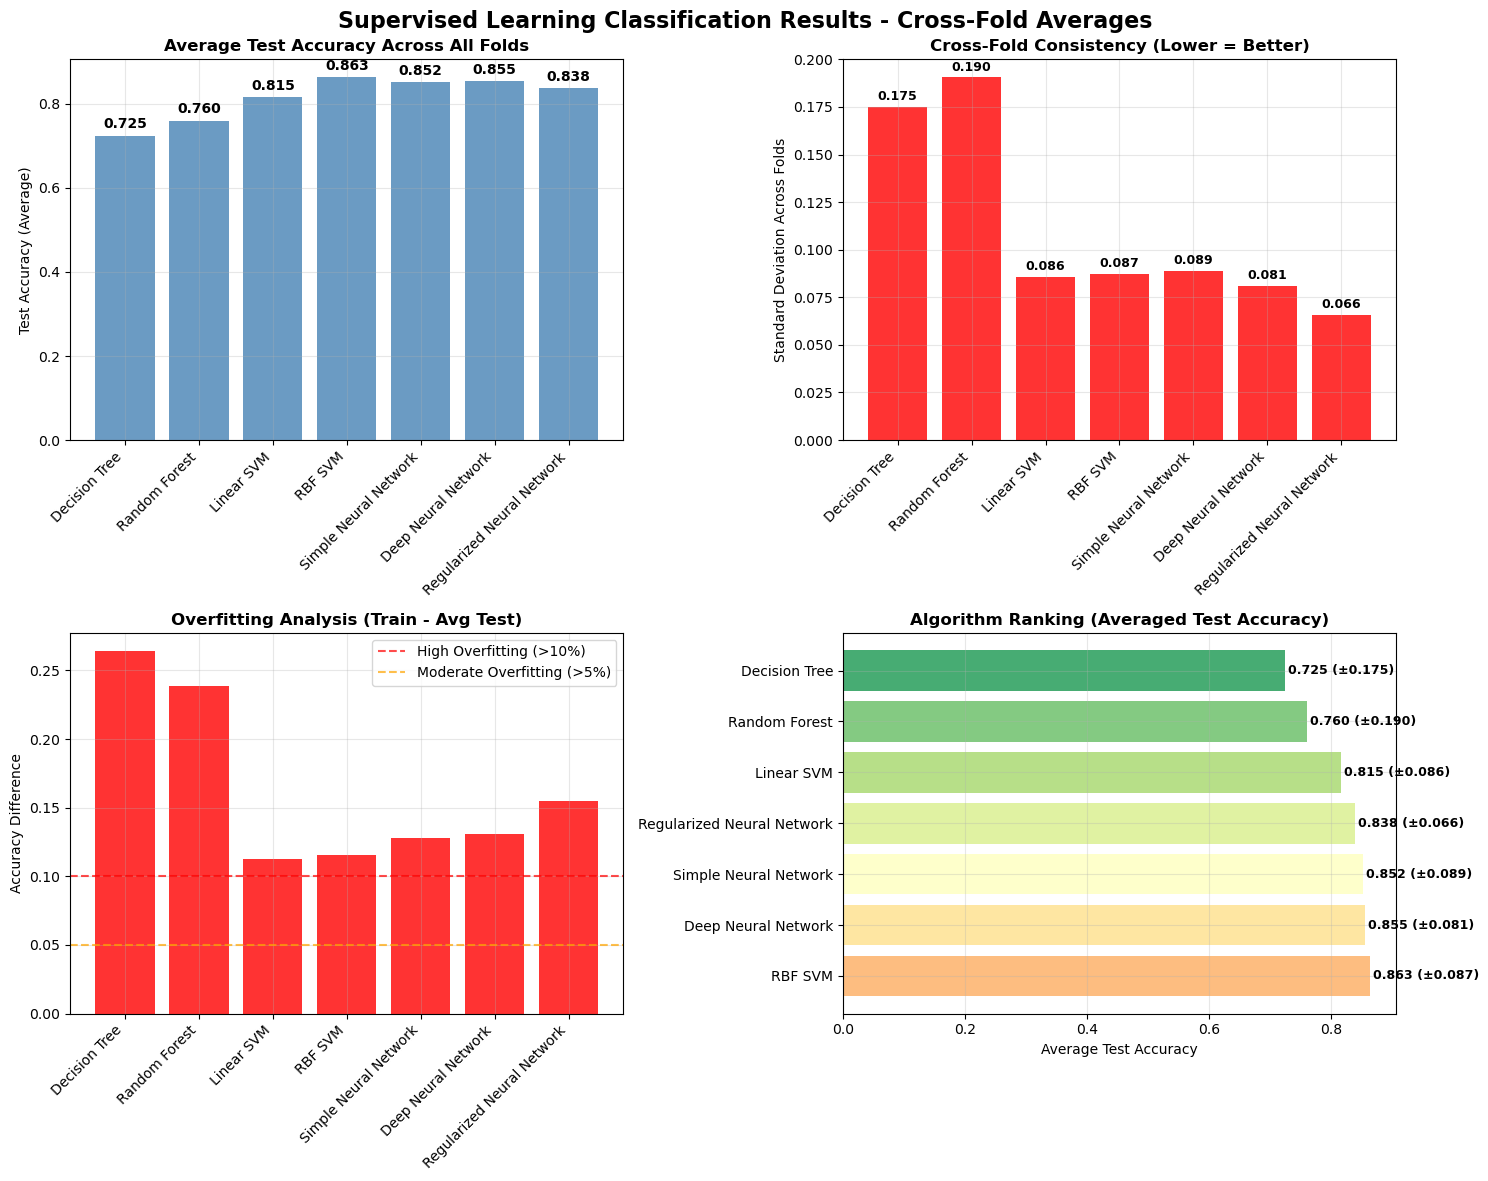


📋 DETAILED RESULTS TABLE - CROSS-FOLD AVERAGES
                 Algorithm Avg Test Accuracy Fold Std Dev Consistency Overfitting Generalization
                   RBF SVM             0.863        0.087      ⚠️ Low       0.115        ⚠️ High
       Deep Neural Network             0.855        0.081      ⚠️ Low       0.131        ⚠️ High
     Simple Neural Network             0.852        0.089      ⚠️ Low       0.128        ⚠️ High
Regularized Neural Network             0.838        0.066      ⚠️ Low       0.155        ⚠️ High
                Linear SVM             0.815        0.086      ⚠️ Low       0.113        ⚠️ High
             Random Forest             0.760        0.190      ⚠️ Low       0.239        ⚠️ High
             Decision Tree             0.725        0.175      ⚠️ Low       0.264        ⚠️ High

📊 CROSS-FOLD SUMMARY STATISTICS
🎯 Best Algorithm: RBF SVM (0.863 ± 0.087)
📈 Average Test Accuracy: 0.815
📉 Worst Algorithm: Decision Tree (0.725 ± 0.175)
🔄 Accuracy Range: 0.1

In [8]:
# ============================================================
# 📈 RESULTS VISUALIZATION AND ANALYSIS - CROSS-FOLD AVERAGES
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from src.supervised_classification import analyze_results_by_category

# Set plotting style
plt.style.use("default")
sns.set_palette("husl")

if (
    "supervised_classifier" in locals()
    and supervised_classifier is not None
    and "fold_accuracies" in locals()
    and fold_accuracies
):

    print("🎯 GENERATING COMPREHENSIVE VISUALIZATIONS - CROSS-FOLD AVERAGES")
    print("=" * 65)

    # ============================================================
    # EXTRACT AVERAGED FOLD RESULTS
    # ============================================================

    # Get model names from original results for consistency
    original_results = supervised_classifier.results
    model_names = [r["model_name"] for r in original_results]

    # Calculate averaged results across all folds
    fold_names = sorted(fold_accuracies.keys())
    averaged_results = []

    for model_name in model_names:
        # Get accuracies across all folds for this model
        fold_accs = [fold_accuracies[fold].get(model_name, 0.0) for fold in fold_names]
        avg_test_acc = np.mean(fold_accs) if fold_accs else 0.0

        # Find corresponding original result for train accuracy and time
        original_result = next(
            (r for r in original_results if r["model_name"] == model_name), None
        )
        train_acc = original_result["train_accuracy"] if original_result else 0.0
        train_time = original_result["training_time"] if original_result else 0.0

        averaged_results.append(
            {
                "model_name": model_name,
                "test_accuracy": avg_test_acc,
                "train_accuracy": train_acc,  # Note: this is from single fold
                "training_time": train_time,
                "fold_variance": np.std(fold_accs) if len(fold_accs) > 1 else 0.0,
            }
        )

    # Extract data for plotting - NOW USING CROSS-FOLD AVERAGES
    test_accuracies = [r["test_accuracy"] for r in averaged_results]
    train_accuracies = [r["train_accuracy"] for r in averaged_results]
    fold_variances = [r["fold_variance"] for r in averaged_results]

    print(f"📊 Using averaged results across {len(fold_names)} folds")
    print(f"   • Fold variance indicates consistency across different data splits")

    # ============================================================
    # 1. PERFORMANCE COMPARISON BAR CHART
    # ============================================================

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(
        "Supervised Learning Classification Results - Cross-Fold Averages",
        fontsize=16,
        fontweight="bold",
    )

    # Bar chart of test accuracies (AVERAGED ACROSS FOLDS)
    bars1 = ax1.bar(
        range(len(model_names)), test_accuracies, alpha=0.8, color="steelblue"
    )
    ax1.set_title("Average Test Accuracy Across All Folds", fontweight="bold")
    ax1.set_ylabel("Test Accuracy (Average)")
    ax1.set_xticks(range(len(model_names)))
    ax1.set_xticklabels(model_names, rotation=45, ha="right")
    ax1.grid(True, alpha=0.3)

    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars1, test_accuracies)):
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0,
            bar.get_height() + 0.01,
            f"{acc:.3f}",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    # ============================================================
    # 2. FOLD CONSISTENCY ANALYSIS (VARIANCE)
    # ============================================================

    # Color by variance (low variance = green, high variance = red)
    colors_variance = [
        "green" if v < 0.02 else "orange" if v < 0.05 else "red" for v in fold_variances
    ]

    bars2 = ax2.bar(
        range(len(model_names)), fold_variances, alpha=0.8, color=colors_variance
    )
    ax2.set_title("Cross-Fold Consistency (Lower = Better)", fontweight="bold")
    ax2.set_ylabel("Standard Deviation Across Folds")
    ax2.set_xticks(range(len(model_names)))
    ax2.set_xticklabels(model_names, rotation=45, ha="right")
    ax2.grid(True, alpha=0.3)

    # Add value labels
    for i, (bar, var) in enumerate(zip(bars2, fold_variances)):
        ax2.text(
            bar.get_x() + bar.get_width() / 2.0,
            bar.get_height() + 0.002,
            f"{var:.3f}",
            ha="center",
            va="bottom",
            fontweight="bold",
            fontsize=9,
        )

    # ============================================================
    # 3. OVERFITTING ANALYSIS (Note: Train is from single fold)
    # ============================================================

    # Calculate overfitting (train - averaged test accuracy)
    overfitting = [
        train - test for train, test in zip(train_accuracies, test_accuracies)
    ]
    colors = [
        "red" if x > 0.1 else "orange" if x > 0.05 else "green" for x in overfitting
    ]

    bars4 = ax3.bar(range(len(model_names)), overfitting, alpha=0.8, color=colors)
    ax3.set_title("Overfitting Analysis (Train - Avg Test)", fontweight="bold")
    ax3.set_ylabel("Accuracy Difference")
    ax3.set_xticks(range(len(model_names)))
    ax3.set_xticklabels(model_names, rotation=45, ha="right")
    ax3.axhline(
        y=0.1, color="red", linestyle="--", alpha=0.7, label="High Overfitting (>10%)"
    )
    ax3.axhline(
        y=0.05,
        color="orange",
        linestyle="--",
        alpha=0.7,
        label="Moderate Overfitting (>5%)",
    )
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # ============================================================
    # 4. ALGORITHM RANKING BY AVERAGED PERFORMANCE
    # ============================================================

    # Sort by averaged test accuracy
    sorted_results = sorted(
        zip(model_names, test_accuracies, fold_variances),
        key=lambda x: x[1],
        reverse=True,
    )
    sorted_names, sorted_accs, sorted_vars = zip(*sorted_results)

    colors_ranking = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(sorted_names)))
    bars5 = ax4.barh(
        range(len(sorted_names)), sorted_accs, alpha=0.8, color=colors_ranking
    )
    ax4.set_title("Algorithm Ranking (Averaged Test Accuracy)", fontweight="bold")
    ax4.set_xlabel("Average Test Accuracy")
    ax4.set_yticks(range(len(sorted_names)))
    ax4.set_yticklabels(sorted_names)
    ax4.grid(True, alpha=0.3)

    # Add value labels with variance info
    for i, (bar, acc, var) in enumerate(zip(bars5, sorted_accs, sorted_vars)):
        ax4.text(
            bar.get_width() + 0.005,
            bar.get_y() + bar.get_height() / 2.0,
            f"{acc:.3f} (±{var:.3f})",
            ha="left",
            va="center",
            fontweight="bold",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()

    # ============================================================
    # 5. DETAILED RESULTS TABLE - CROSS-FOLD AVERAGES
    # ============================================================

    print("\n📋 DETAILED RESULTS TABLE - CROSS-FOLD AVERAGES")
    print("=" * 70)

    # Create DataFrame for better visualization
    df_results = pd.DataFrame(
        {
            "Algorithm": model_names,
            "Avg Test Accuracy": [f"{acc:.3f}" for acc in test_accuracies],
            "Fold Std Dev": [f"{var:.3f}" for var in fold_variances],
            "Consistency": [
                "✅ High" if var < 0.02 else "🔶 Medium" if var < 0.05 else "⚠️ Low"
                for var in fold_variances
            ],
            "Overfitting": [f"{diff:.3f}" for diff in overfitting],
            "Generalization": [
                "⚠️ High" if diff > 0.1 else "🔶 Moderate" if diff > 0.05 else "✅ Good"
                for diff in overfitting
            ],
        }
    )

    # Sort by averaged test accuracy
    df_results = df_results.sort_values("Avg Test Accuracy", ascending=False)
    print(df_results.to_string(index=False))

    # ============================================================
    # 6. SUMMARY STATISTICS - CROSS-FOLD AVERAGES
    # ============================================================

    print(f"\n📊 CROSS-FOLD SUMMARY STATISTICS")
    print("=" * 40)
    print(
        f"🎯 Best Algorithm: {sorted_names[0]} ({sorted_accs[0]:.3f} ± {sorted_vars[0]:.3f})"
    )
    print(f"📈 Average Test Accuracy: {np.mean(test_accuracies):.3f}")
    print(
        f"📉 Worst Algorithm: {sorted_names[-1]} ({sorted_accs[-1]:.3f} ± {sorted_vars[-1]:.3f})"
    )
    print(f"🔄 Accuracy Range: {max(test_accuracies) - min(test_accuracies):.3f}")

    # Count consistency levels
    high_consistency = sum(1 for x in fold_variances if x < 0.02)
    medium_consistency = sum(1 for x in fold_variances if 0.02 <= x < 0.05)
    low_consistency = sum(1 for x in fold_variances if x >= 0.05)

    print(f"\n🔄 CROSS-FOLD CONSISTENCY ANALYSIS:")
    print(
        f"   ✅ High Consistency: {high_consistency}/{len(averaged_results)} algorithms"
    )
    print(
        f"   🔶 Medium Consistency: {medium_consistency}/{len(averaged_results)} algorithms"
    )
    print(f"   ⚠️ Low Consistency: {low_consistency}/{len(averaged_results)} algorithms")

    # Most consistent algorithm
    most_consistent = min(zip(model_names, fold_variances), key=lambda x: x[1])
    print(
        f"\n🏆 Most Consistent Algorithm: {most_consistent[0]} (std: {most_consistent[1]:.3f})"
    )

    print(f"\n🎓 CROSS-FOLD LEARNING INSIGHTS:")
    print(f"   • Results averaged across {len(fold_names)} cross-validation folds")
    print(f"   • Consistency measured by standard deviation across folds")
    print(f"   • Best algorithm combines high accuracy with low variance")
    print(f"   • Classes analyzed: {selected_classes}")

    print(
        f"\n✅ Cross-fold visualization complete! Robust performance estimates ready."
    )

else:
    print("❌ No cross-fold results available.")
    print("💡 Please run all the previous cells first:")
    print("   1. Data loading and configuration")
    print("   2. Model training and validation")
    print("   3. Cross-fold validation analysis")
    print("\nThen re-run this cell to see cross-fold averaged visualizations.")